# COMPAS 

COMPAS er en algoritme utvikla for å anslå hvor trolig det er at en sikta person vil begå nye straffbare handlinger, og brukes utbredt i amerikansk rettvesen. Da nettavisen ProPublica i 2016 tok for seg ulike deler av algoritmen, synes det gjennomgående at algoritmen på bakgrunn av etnisitet ga hvite et lavere risikoanslag enn svarte. Vi skal i denne analysen ta for oss ulike deler av algoritmen gjennom å reprodusere resultatene til ProPublica. I den tilhørende etiske rapporten diskuterer vi behovet og det etiske grunnlaget for en slik algoritme.

## Datasettet

ProPublica hentet data om innsatte i Broward County, Florida, USA, og gjorde sin analyse av COMPAS basert på denne dataen. ProPublica har gjort dette datasettet fritt tilgjengelig, og det er det vi bruker i vår analyse.

Vi omformer kolonnene i datasettet noe, og ender opp med følgende kolonner som relevante for vår analyse:
 - Kolonnen `sex` angir kjønnet til personen 
 - Kolonnen `white` angir om personen er "hvit" eller ikke, hvor vi definerer hvit som gruppen "Caucasian" i det originale datasettet
 - Kolonnen `score` gir scoren som COMPAS ga personen
 - Kolonnen `predicted` indikerer om COMPAS predikerte personen til å begå nye lovbrudd
 - Kolonnen `actual` indikerer om personen faktisk begikk nye lovbrudd

For å skille på etnisitet har vi valgt å forholde oss til gruppene "hvite" og "ikke-hvite". Dette skillet er lett å forholde seg til, og unngår problemer med nyanser og at noen tilfeller kan "falle mellom to stoler". Vi får også på denne måten brukt hele datasettet.

In [1]:
import pandas as pd
import matplotlib.ticker as mtick
from IPython.core.display import display, HTML

def display_df_pct(df):
    display(HTML(df.to_html(float_format=lambda x: f'{x*100:.1f}%')))

data = pd.read_csv("../data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]
df = pd.DataFrame({ 
    "sex": data.sex,
    "white": data.race == "Caucasian",
    "score": data.decile_score,
    "predicted": data.score_text != "Low",
    "actual": data.is_recid == 1
})
df

,sex,white,score,predicted,actual
0,Male,False,1,False,False
1,Male,False,3,False,True
2,Male,False,4,False,True
5,Male,False,1,False,False
6,Male,True,6,True,True
...,...,...,...,...,...
7209,Male,False,7,True,False
7210,Male,False,3,False,False
7211,Male,False,1,False,False
7212,Female,False,2,False,False


## Predikerte og faktisk gjentatte forbrytelser

For å få oversikt over hvor ofte ulike grupper faktisk gjorde nye lovbrudd og blir predikert å begå nye lovbrudd lager vi firefeltstabeller. Tabellene gir en pekepinn på hvor presis algoritmen er, og hvordan den behandler ulike grupper ulikt.

I firefeltstabellen har vi rader for gruppa vi ser på og resten av datasettet, og kolonner for hvor stor andel av tilfellene i hver gruppe som blir predikert å begå nye lovbrudd og hvor stor andel av tilfellene som faktisk begår nye lovbrudd.

In [2]:
def get_relative_frequency(group, target):
    group_size = len(df[group])
    target_size = len(df[group & target])
    rel_freq = target_size/group_size
    return f'{rel_freq*100:.1f}%'

def four_field_table(group, group_name, rest_name):
    return pd.DataFrame({
        "Predikert": [get_relative_frequency(group, df.predicted), get_relative_frequency(~group, df.predicted)],
        "Faktisk": [get_relative_frequency(group, df.actual), get_relative_frequency(~group, df.actual)],
    }, index = [group_name, rest_name])

### Predikerte og faktisk gjentatte forbrytelser etter etnisitet

In [3]:
four_field_table(df.white, "Hvite", "Ikke-hvite")

,Predikert,Faktisk
Hvite,33.1%,41.6%
Ikke-hvite,50.5%,52.0%


### Predikerte og faktisk gjentatte forbrytelser etter kjønn

In [4]:
four_field_table(df.sex == 'Male', "Menn", "Kvinner")

,Predikert,Faktisk
Menn,45.5%,51.1%
Kvinner,40.5%,37.0%


Fra de to tabellene ser vi at det blant hvite er 8 prosentpoeng færre som blir predikert å begå nye lovbrudd enn som faktisk gjør det.
Det tilsvarende tallet for ikke-hvite er kun 2 prosentpoeng.
For menn er det 6 prosentpoeng, og for kvinner -4 prosentpoeng.

Dette tyder på en "overprediksjon" for kvinner og betraktelig større "underprediksjon" for hvite enn ikke-hvite.

## Fordeling av predikert risiko

COMPAS-algoritmen gir i utgangspunktet ikke en binær prediksjon, men en score mellom 1 og 10 som indikerer risiko for at personen vil begå nye lovbrudd. Vi ser på fordelingen av score i forskjellige inndelinger. Dette gir et bedre innblikk i hva algoritmen faktisk predikerer enn i firefeltstabellene ovenfor.

In [5]:
def plot_score_dist(df, title, group, group_name, rest_name, all_name = 'Alle'):
    ax = pd.DataFrame({
        all_name: df.score.value_counts(normalize = True),
        group_name: df[group].score.value_counts(normalize = True),
        rest_name: df[~group].score.value_counts(normalize = True)
    }).sort_index().plot.bar(title = title, style = {all_name: "k--"})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


### Fordeling av score etter etnisitet

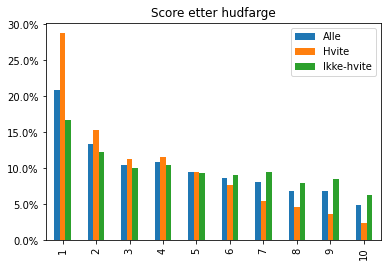

In [6]:
plot_score_dist(df, "Score etter etnisitet", df.white, "Hvite", "Ikke-hvite")

Vi ser at blant hvite (de oransje søylene) er det nesten 30% som får score 1, og en sterkt avtagende tendens for høyere scorer. Fra score 5 ligger hvite under snittet for hele datasettet.

For ikke-hvite (de grønne søyelen) ser vi motsatt tendens. For score 1 til 5 er andel av ikke-hvite lavere enn andelen av hele datasettet for hver score. Fra score 6 til 10 er andelen konsekvent høyere. Grovt kan vi altså si at ikke-hvite i mindre grad får lavere scorer og i større grad får høyere scorer.

### Fordeling av score etter kjønn

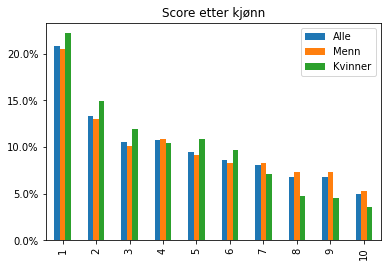

In [7]:
plot_score_dist(df, "Score etter kjønn", df.sex == 'Male', "Menn", "Kvinner")

Fordelt på kjønn er forskjellene mye mindre enn vi så med etnisitet.

### Fordeling av score etter gjentatt forbrytelse

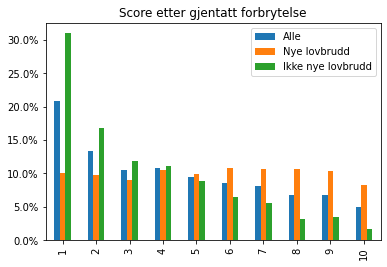

In [8]:
plot_score_dist(df, "Score etter gjentatt forbrytelse", df.actual, "Nye lovbrudd", "Ikke nye lovbrudd")

I dette diagrammet ser vi på fordelingen av score gruppert etter om personene faktisk endte med å begå nye lovbrudd i løpet av to år etter algoritmens prediksjon. Vi ser altså på data som ikke er tilgjenglig mens algoritmen er i bruk.

For person som ikke gjorde nye lovbrudd (grønn),  ser vi en tydelig avtakende tendens mot høyrer scorer. Dette stemmer godt med det man ville forvente å se i en presis algoritme.

### Fordeling av score etter gjentatte forbrytelser og etnisitet

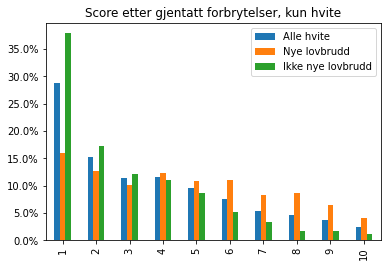

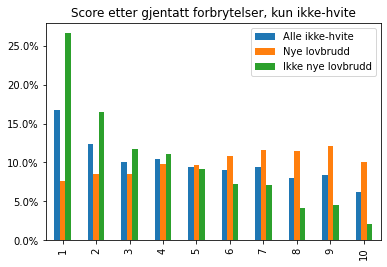

In [23]:
df_white = df[df.white]
plot_score_dist(df_white, "Score etter gjentatt forbrytelser, kun hvite", df_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd", "Alle hvite")
df_non_white = df[~df.white]
plot_score_dist(df_non_white, "Score etter gjentatt forbrytelser, kun ikke-hvite", df_non_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd", "Alle ikke-hvite")

Legg merke til at y-akesene er forskjellige. Blant hvite ser vi at over 35% av de som ikke begikk nye lovbrudd fikk laveste score, blant ikke-hvite var denne andelen kun 25%. For ikke-hvite er andelen som får hver av scorene 6 til 10 av de som begikk nye lovbrudd rett over 10%. Dette speiles ikke blant hvite - der er andelen 10% som får score 6, men fra 7 og utover er andelen dalende. Dette tyder igjen på en negativ favorisering av ikke-hvite.

## Betinget sannsynlighet

I steden for å kun se på andeler, kan vi gjøre sannsynlighetsberegninger basert på dataen vår. Vi vil være interessert i positiv prediktiv verdi og sensitivitet.

Positiv prediktiv verdi er sannsynligheten for at en person som ble predikert å begå nye lovbrudd faktisk begår nye lovbrudd.Sensitivitet er det "motsatte": sannsynligheten for at en person som faktisk begikk nye lovbrudd ble predikert å gjøre det.

For rettsvernet og enkeltmennesket kan det tenkes at den positive prediktive verdien bør veie tyngre enn sensitiviteten. (Vi ønsker ikke en algoritme som dømmer uskyldige mennesker.)
Samtidig må samfunnssikkerheten også vurderes: ved å øke sensitiviteten beskytter vi trolig innbyggerne mot kriminalitet. 

For å regne på sammenhengen mellom positiv prediktiv verdi og sensitivitet ser vi på de matematiske definisjonene.
$$
\begin{align}
A &= \textrm {Tilbakefall} \\
B &= \textrm {Predikert tilbakefall} \\ 
\textrm {Positiv prediktiv verdi} &= P(A | B) \\
\textrm {Sensitivitet} &= P(B | A) \\
\end{align}
$$

Vi kan bruke Bayes setning for å se hvordan de to sannsynlighetene virker sammen:
$$
\begin{align}
P(A | B) &= \frac{P(B | A) \cdot P(A)} {P(B)} \\
P(B | A) &= \frac{P(A | B) \cdot P(B)} {P(A)}
\end{align}
$$

En presis algoritme vil både få høy positiv prediktiv verdi og sensitivitet. Den beste måten å øke disse verdiene er derfor å utvikle en mer presis algoritme. En annen mulighet er likevel å endre hvilken score man begynner å predikere positiv eller negativ verdi for. Ved å predikere flere til å begå nye lovbrudd ved lavere score (tilsvarer høyere $B$), kan vi lese fra Bayes setning at sensitiviteten vil bli høyere, men den positive prediktive verdien vli bli tilsvarende lavere.

På samme måte kan vi flytte prediksjonen til høyere score (tilsvarer lavere $B$) for å få høyere positiv prediktiv verdi, men får da også lavere sensitivitet. Vi må altså bestemme hvor vi går fra negative til positive prediksjoner ved å balansere den positive prediktive verdien mot sensitiviteten. 

Vi ser nå på positiv prediktiv verdi og sensitivitete blant gruppene vi har studert tidligere. Samtidig lager vi firefeltstabeller som gir verdiene for sanne og falske negative og positive.

In [11]:
def conditional_prob(df):
    a = pd.DataFrame({
        "Ikke gjentatt": df[~df.actual].predicted.value_counts().sort_index(),
        "Gjentatt lovbrudd": df[df.actual].predicted.value_counts().sort_index()
    }).rename({False: "Ikke predikert", True: "Predikert"}) / len(df)
    display_df_pct(a)
    pos_pred = a["Gjentatt lovbrudd"]["Predikert"] / a.loc["Predikert"].sum()
    print(f"Pos. pred. verdi: {pos_pred*100:.1f}%")
    sens = a["Gjentatt lovbrudd"]["Predikert"] / a["Gjentatt lovbrudd"].sum()
    print(f"    Sensitivitet: {sens*100:.1f}%")

### Alle

In [12]:
conditional_prob(df)

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,36.4%,19.0%
Predikert,15.1%,29.4%


Pos. pred. verdi: 66.0%
    Sensitivitet: 60.8%


### Hvite

In [13]:
conditional_prob(df[df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,45.8%,21.1%
Predikert,12.6%,20.4%


Pos. pred. verdi: 61.8%
    Sensitivitet: 49.2%


### Ikke-hvite

In [14]:
conditional_prob(df[~df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,31.6%,17.9%
Predikert,16.4%,34.1%


Pos. pred. verdi: 67.5%
    Sensitivitet: 65.5%


### Menn

In [15]:
conditional_prob(df[df.sex == 'Male'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,34.6%,19.9%
Predikert,14.3%,31.2%


Pos. pred. verdi: 68.6%
    Sensitivitet: 61.1%


### Kvinner

In [16]:
conditional_prob(df[df.sex == 'Female'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,44.3%,15.2%
Predikert,18.7%,21.8%


Pos. pred. verdi: 53.8%
    Sensitivitet: 58.9%


I firefeltstabellen er de sanne negative finnes øverst til venstre, falske negative øverst til høyre, falske positive nederst til venstre og de sanne positive nederst til høyre. 
Fordelingen av disse når man sammenlikner hvite og ikke-hvite kan indikere at algoritmen er diskriminerende overfor ikke-hvite. Vi ser at andelen falske positive er større for ikke-hvite enn hvite, samtidig som andelen falske negative er større blant hvite. Denne forskjellen reflekteres i sensitiviteten, som er markant lavere hos hvite enn ikke-hvite. Dette tyder på at algoritmen er mer aggressiv når det kommer til å predikere tilbakefall hos ikke-hvite enn hvite. Den lave sensitiviteten hos hvite indikerer kan indikere at deres rettssikkerhet i større grad blir ivaretatt enn hos ikke-hvite. 

Det er også verdt å merke at kvinner har betraktelig lavere positiv prediktiv verdi (53,8%) enn alle (66%). Algoritmen tar oftere feil for kvinner enn for menn. 

Til tross for at disse funnene støtter opp om at COMPAS er diskriminerende, kan ikke konkludere før vi har isolert faktorene. 

# Isolere en variabel

Forskjeller i andeler og sannsynligheter mellom hvite og ikke-hvite er ikke et bevis på rasisme eller diskriminering. Dersom ikke-hvite i større grad enn hvite har kriminelle rulleblad, og algoritmen gir personer med kriminelt rulleblad større sannsynlighet for å begå nye lovbrudd, vil ikke-hvite komme ut dårligere enn hvite i sammenlikninger som de over. For å bøte på dette, kan vi isolere etnisitet som variabel, og se på hvilken innvirkning etnisitet i seg selv har på prediksjonen fra algoritmen. 

For å gjøre dette trener vi en logistisk modell som skal etterligne COMPAS sine prediksjoner. Den trente modellen vil ha forskjellige vekter for hver kolonne vi lar den trene på. Ved hjelp av vekten til en kolonne kan vi beregne hvor viktig den kolonnen er alene i en prediksjon. Det vil si i hvor stor grad kolonnen bestemmer resultatet, selv om alle andre parametere er like.

In [24]:
from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

Y = data["score_text"] != "Low"

model = LogisticRegression(max_iter=1000)
model.fit(X, Y)

LogisticRegression(max_iter=1000)

Med alle vektene og bias, kalkulerer vi bias mot "African-American" som gruppe, ved å sammenlikne en idealisert person som ikke har noen egenskaper, mot en person som kun har egenskapen å være "African-American". "African-American" inngår i gruppen ikke-hvit som vi har brukt så langt, men er mer spesifikk.

In [18]:
black_coef = model.coef_[0, list(X.columns).index('race_African-American')]
intercept = model.intercept_[0]

control = 1/(1+np.exp(-intercept))
racialBias = np.exp(black_coef) / (1 + control * (np.exp(black_coef) - 1))
racialBias

1.453084453051661

Tallet forteller oss at det å være "African-American" gir en 45% større sjanse for å bli predikert å begå nye lovbrudd, uavhengig av kriminelt rulleblad og andre kolonner i datasettet vårt. Dette gir en sterk indikasjon på at algoritmen er diskriminerende.

Vi ser også på "partial dependence", som forteller forventningsverdien av prediksjonen når kun en variabel er låst.

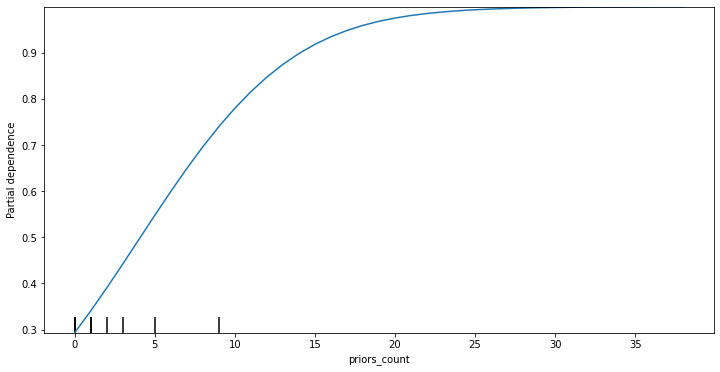

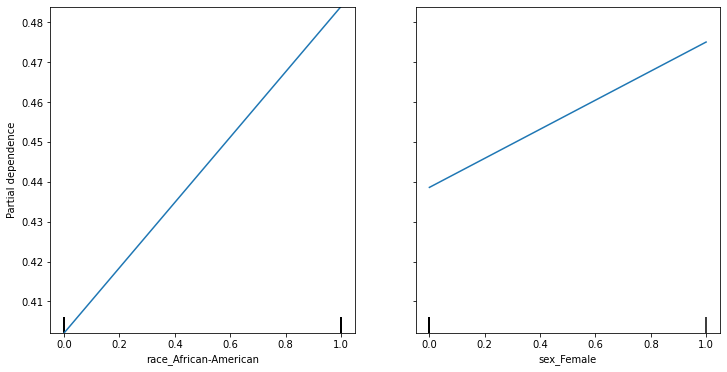

In [30]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

plot_partial_dependence(model, X, ["priors_count"])
plt.gcf().set_size_inches(12, 6)
plot_partial_dependence(model, X, ["race_African-American", "sex_Female"])
plt.gcf().set_size_inches(12, 6)

Vi ser at `priors_count` har stor partial dependence. En person med 10 tidligere lovbrudd har nesten 80% sannsynlighet for å bli predikert å begå nye lovbrudd. 
Det å ikke være "African-American" bærer med seg 40% sannsynlighet for å bli predikert å begå nye lovbrudd, mens det å være "African-American" gir over 48%. En tilsvarende effekt ser vi blant kvinner og menn, hvor menn har 44% sannsynlighet og kvinner har 47% sannsynlighet for å bli predikert å begå nye lovbrudd.

## Mulige feilkilder

Strukturell rasisme og diskrimering i rettsystemet gjør det vanskelig å skille diskriminering i samfunnet, fra diskriminering i COMPAS.

Selv om vi har fått gode beviser på at COMPAS er diskriminerende, vil vi nevne at det kan finnes bakenforliggende forhold (for eksempel sosioøkonomisk status, osv) som ikke er inkludert i datasettet, men plukkes opp i etnisitet. Disse kan forklare større andeler positive prediksjoner for ikke-hvite i COMPAS, med skjevheter i samfunnet. I mangelen på disse bakenforliggende forholdene kan det likevel argumenteres for at COMPAS da ikke burde hatt tilgang på informasjon om etnisitet i det hele tatt.
Andre feilkilder er et smalt datasett (kun ett politidistrikt), feilregistreringer og andre feil i datagrunnlaget. Vår logistiske modell gir dessuten ikke et perfekt bilde av partial dependence i den faktiske COMPAS-modellen.


## Konklusjon

Ved å se på andelene som blir predikert å begå nye lovbrudd og faktisk begår nye lovbrudd i forskjellige grupper, samt fordelingen av forskjellige risiko-scorer og betingede sannsynligheterfikk vi tidlig inntrykk av at COMPAS-algoritmen diskriminerer mot ikke-hvite. Vi trente en logistisk modell for å etterlikne COMPAS, og ser at denne får en skjevhet på 45% mot ikke-hvite, og har tydelig "partial dependence" på det å være "African-American". Dette bekrefter intrykket og gir gode beviser for at COMPAS virker diskriminerende mot ikke-hvite.

## Kilder
 - Angwin, Julia; Larson, Jeff; Mattu, Surya and Kirchner, Lauren. ProPublica, May 23, 2016: "Machine Bias". https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing
 -  Larson, Jeff; Mattu, Surya; Kirchner, Lauren and Angwin, Julia. ProPublica, May 23, 2016: "Machine Bias". https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm